# Where's the Best Place to Sell Books Online?
The e-commerce platform Flipkart hit an all-important milestone in 2018.
After beating out the world's largest online business, Amazon, for holding the top position in India's online retail market, the startup was acquired for by Wal-Mart for $18B USD.

It is commonly believed that startups can beat out larger businesses through differentiation, or being unique.

Will a machine learning classifier show us the differences between books being sold on Amazon vs. Flipkart?

# Setup for Data Analysis and ML Classifications

In [77]:
# Exploratory Data Analysis libraries
import pandas as pd
import numpy as np
# visualizations
import seaborn as sns 
# run Matplotlib graphs inline in notebook
import matplotlib.pyplot as plt  
%matplotlib inline
# Machine Learning libraries 
import sklearn
# function used in building ML algorithms
from sklearn.model_selection import train_test_split
# imports the class to do standard scaling
from sklearn.preprocessing import StandardScaler, MinMaxScaler
# Performing PCA
from sklearn.decomposition import PCA
# Model Evaluation
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
# Sklearn Tools the ML Algorithms
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

### Instantiating pandas DataFrames

In [78]:
amazon_df = pd.read_csv('Data/amazon.csv')
flipkart_df = pd.read_csv('Data/flipkart.csv')
# View the data for book listings on Amazon
amazon_df.head()

,amazon_title,amazon_author,amazon_rating,amazon_reviews count,amazon_isbn-10,amazon_price
0,Tell Me your Dreams,by Sidney Sheldon,4.4,160.0,8172234902,209
1,The Boy in the Striped Pyjamas (Definitions),by John Boyne,4.6,134.0,1862305277,350
2,Romancing the Balance Sheet: For Anyone Who Ow...,by Anil Lamba,4.5,156.0,9350294311,477
3,Mossad,by Michael Bar-Zohar - Import,4.6,637.0,8184958455,340
4,My Story,by Kamala Das,4.5,42.0,8172238975,178


In [79]:
# do the same for Flipkart books sold
flipkart_df.head()

,flipkart_author,flipkart_isbn10,flipkart_title,flipkart_ratings count,flipkart_price,flipkart_stars
0,Sidney Sheldon,8172234902,TELL ME YOUR DREAMS,902,209,4.5
1,,1862305277,The Boy in the Striped Pyjamas,83,372,4.5
2,Anil Lamba,9350294311,ROMANCING THE BALANCE SHEET,352,477,4.5
3,Bar-Zohar Michael,8184958455,Mossad,560,280,4.5
4,Kamala Das,8172238975,MY STORY,322,178,4.3


## Fixing Data Inconsistencies

Several problems with the data have been identified, as it pertains to this analysis:

1. Columns are named differently across DataFrames
2. The columns are ordered differently across DataFrames
3. Books with the same title have different casing across DataFrames
4. Data type for ratings count is all floats on Amazon data, yet integers for the analogous column on the Flipkart Dataframe.
5. ISBN columns offers seeminly useless information.
6. Different kinds of NaN values exist in the author columns on both DataFrames (i.e. "By NA", "Not Available", or just leaving the cell empty).
7. Prices are missing the proper decimal point.

### Normalizing Prices

In [80]:
# Assumes that prices were listed originally in USD
amzn_prices = amazon_df['amazon_price']
amazon_df['amazon_price'] = [price/100 for price in amzn_prices]

fp_prices = flipkart_df['flipkart_price']
flipkart_df['flipkart_price'] = [price/100 for price in fp_prices]

### Making Column Names Consistent

In [81]:
def cutoff_prefix(df, prefix_length):
    '''Removes the first prefix_length characters from each column in a DataFrame.'''
    col_names = list(df.columns)
    for i in range(len(col_names)):
        # slicing off the first 7 letters
        label = col_names[i]
        col_names[i] = label[prefix_length:]
    # swap out the names in the df for their shortened versions
    new_df = df
    new_df.columns = col_names
    return new_df

# Store new Dataframes whose column names have been shorted
amzn_df = cutoff_prefix(amazon_df, 7)
fp_df = cutoff_prefix(flipkart_df, 9)

### Combining Data into One

**The Ratings/Reviews Count Column**

As I continue pre-processing data, there are a few things to keep in mind. For one thing, there is no contextual benefit in providing the number of reviews as a floating point number, as opposed to an integer. Therefore, I will convert all the floating point values in the "reviews count" column of the Amazon DataFrame to integer values.

In [82]:
# do the ratings/reviews columns have the same number of values to begin with?
print(len(amzn_df['reviews count']) == len(fp_df['ratings count']))
# let's make sure that both reviews count columns have the same number of non-Nan values
print(len(amzn_df['reviews count'].dropna().values) == len(fp_df['ratings count'].dropna().values))

True
False


In [83]:
# alright, so which df has more values?
print(len(amzn_df['reviews count'].dropna().values))
print(len(fp_df['ratings count'].dropna().values))

1378
1382


Okay, so as a heads-up I will need to fill in some NaN values in the Amazon Dataframe!
Here, I decided to fill in using '0.0'.

In [84]:
amzn_df['reviews count'] = amzn_df['reviews count'].fillna('0.0')

In [85]:
def remove_commas_from_strings(df, col):
    '''Int conversion for review counts.'''
    counts = list()
    for count in df[col]:
        # removing commas, filling in empty strings
        if ',' in count:
            count_ls = [char for char in count if char != ',']
            count = ''.join(count_ls)
        elif count == ' ':
            count = '0.0'
        counts.append(float(count))                             
    # replacing the column in the DataFrame
    df[col] = counts
    return  # signalling end of function
  
remove_commas_from_strings(amzn_df, 'reviews count')
remove_commas_from_strings(fp_df, 'ratings count')
remove_commas_from_strings(fp_df, 'stars')

Cool! That was way more complicated than expected. 

**Handling NaN Values + Mismatching Column Naming**

For future reference, how about we cross-inspect of all the columns from both DataFrames, so we can:

1. Take note of where differences in column-naming may be an issue,
2. Take note of where Nan values may be an issue,
3. Decide how best to resolve that issues in the context of that column!

In [86]:
amzn_df.columns

Index(['title', 'author', 'rating', 'reviews count', 'isbn-10', 'price'], dtype='object')

In [87]:
fp_df.columns

Index(['author', 'isbn10', 'title', 'ratings count', 'price', 'stars'], dtype='object')

Interesting! It looks like I need to resolve a naming conflict in Flipkart's DataFrame, for the following columns:

- 'stars'
- 'ratings count'

I chose to do this by simply renaming these columns to their Amazonian counterparts. The ISBN columns were simply dropped from both DataFrames, because they will not be used in the analysis to come.

In [88]:
# Renaming Flipkart columns mismatched names
fp_df = fp_df.rename(columns={
    'stars': 'rating',
    'ratings count': 'reviews count'
})
# Removing the ISBN columns of both DataFrames
del amzn_df['isbn-10']
del fp_df['isbn10']

To make the for-loop in the next cell functional, I must first resolve the naming conflict between 'reviews count' and 'ratings count', and likewise for 'review.'

In [89]:
# I assume that with NaN values included, both DataFrames are already the same length.
for col in amzn_df.columns:
    # skipping rating and reviews, since we already did that
    if col != 'reviews count':
        num_valid_rows_am = len(amzn_df[col].dropna().values)
        num_valid_rows_fp = len(fp_df[col].dropna().values)
        print(f"For '{col}', Amazonian data shows {num_valid_rows_am} values, and Flipkart data shows {num_valid_rows_fp} values.")

For 'title', Amazonian data shows 1382 values, and Flipkart data shows 1382 values.
For 'author', Amazonian data shows 1382 values, and Flipkart data shows 1382 values.
For 'rating', Amazonian data shows 1378 values, and Flipkart data shows 1382 values.
For 'price', Amazonian data shows 1382 values, and Flipkart data shows 1382 values.


We can also make sure that the columns in both DataFrames are labeled the same way, to save us any headache in the future in case we need to be compared to one another.

In [90]:
# reorder columns in df2 to match df1
fp_df = fp_df[amzn_df.columns]

It looks like we almost match up... except Amazon is lacking 4 non-NaN values in its 'rating' column. This is reasonable, because presumably these were the same rows in which the values for 'reviews count' were also missing.

As before I will in those NaN values with '0.0', with the rationale being:
1. That is what they most likely were, if they were missing during the stage of actually collecting the data;
2. Ratings for books tend to depend on the book's quality; so it would not make sense to use another technique such as GMM for instance, because the value a book gets for its rating should arguably treated as an individual value. That is to say, it should not be confined to the distribution of rating values for this overall dataset.

In [91]:
amzn_df['rating'] = amzn_df['rating'].fillna('0.0')
fp_df['rating'] = fp_df['rating'].fillna('0.0')

It also makes sense make sure all the values in the 'rating' and 'reviews count' columns are numerical!

In [92]:
def convert_str_to_float(df, col):
    '''Modifies the column of the df so that all its NaN strings become floating point numbers.'''
    # special case, because Flipkart's df contains empty strings
    if df[col].all() == fp_df[col].all() and col == 'rating':
        df_values = list()
        for i in range(len(df.iloc[:])):
            value = df[col].iloc[i][:4]
            # we found an empty string
            if value == ' ':
                vaue = 0.0
            df_values.append(value)
    # Case for Amazon's Ratings, which are suffixed by 'out of 5 stars'
    elif col == 'rating':
         df_values = [float(value[:3]) for value in df[col].iloc[:]]
    # Case for Review Count
    else:
        df_values = [float(value) for value in df[col].iloc[:]]
    # copy the new values back into the old df
    df[col] = df_values


# Changing Amazon Ratings from Strings to Floating Point
convert_str_to_float(amzn_df, 'rating')

**Adding a 'Company' Column**

In preparation of combining the two DataFrames, I will also add a 'Company' column to both, so that we will able to tell which row came from which company once they are all together!

In [93]:
def add_company_col(df, company_name):
    '''Add a column to specify which company through which a book was listed on the Internet.'''
    df['Is_Amazon'] = [company_name for i in range(len(df))]
    
add_company_col(amzn_df, 1.0)  # 1 is affirmative
add_company_col(fp_df, 0.0)  # 0 is negative

**Stacking DataFrames on Top of Each Other**

In [94]:
def collect_rows(df1, df2, is_stacked):
    """Make a new DataFrames in which all rows from df1 and df2 are combined into one.
    
       Parameters:
       df1(DataFrame): the DataFrame which the return value will be initialized from, by copying.
       df2(DataFrame): the DataFrame whose rows will be added to the copy.
       is_stacked(bool): specificies whether all the rows of df2 will go beneath all the rows in df1, or if False
                         then the return df will alternate between rows of df1 and df2 in its ordering, i.e. each
                         row from one company's DataFrame will be followed by the row in the other DataFrame for the
                         same book.
                         
      Returns: DataFrame
    
    """
    if is_stacked is True:
         # create an empty DataFrame to hold all the eventual data
        merged = pd.DataFrame(data=None, index=list(range(len(df1) + len(df2))), columns=df1.columns)
        # add all rows in df2 below all rows df1, in order by corresponding columns
        for col in df1.columns:
            # form a new column with both sets of data, one after the other
            new_col = df1[col].append(df2[col], ignore_index=True)
            # add it to the new df
            merged[col] = (new_col)
    else:
        merged = pd.DataFrame(data=None, index=list(range(len(df1) + len(df2))), columns=df1.columns)
        # iterate through all rows of both df's
        for i in range(len(df1)):
            row1, row2 = df1.iloc[i], df2.iloc[i]
            # add in the rows
            merged = merged.append(row1, ignore_index=True)
            merged = merged.append(row2, ignore_index=True)
        # Not completely clear on why the above causes top half of merged to be NaN, for now I'll just cut it out
        merged = merged.iloc[len(merged) // 2:]
    return merged

all_books_stacked = collect_rows(amzn_df, fp_df, True)
all_books_mixed = collect_rows(amzn_df, fp_df, False)

# Exploratory Data Analysis

## How Similar Are the Distributions of Price, Rating, and Review Counts?
These look like the most promising features to use in training our classifier. Are they noticeably different between the two companies?

#### Which features should be used to train the model?
While on the topic, the "title" and "author" columns will not be used to train the classifier. In the context of an application, where a user would enter in the price their desired price for a book, the title they provide will not actually help the classifer in its decision. Rather, it would merely serve to let the machine know amongst which platforms (or labels for the target class) it can choose amongst.

## How Similar are Books to One Another?

### Scatter Plot of Books on Amazon

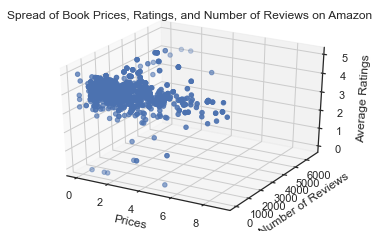

In [95]:
def plot_3D(df, company_name):    
    ax = plt.subplot(projection="3d")
    ax.scatter3D(df['price'],
                 df['reviews count'],
                 df['rating'])
    ax.set_xlabel('Prices')
    ax.set_ylabel('Number of Reviews')
    ax.set_zlabel('Average Ratings')
    ax.set_title(f'Spread of Book Prices, Ratings, and Number of Reviews on {company_name}')
    plt.show()
    
plot_3D(amzn_df, 'Amazon')

### Scatter Plot of Books on Flipkart

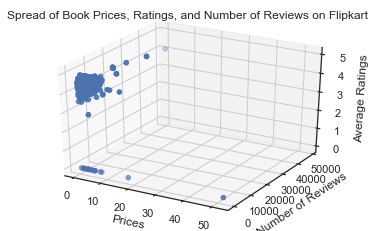

In [96]:
plot_3D(fp_df, 'Flipkart')

Looks like we have our work cut out for this!
Books on neither platform appear to have high covariance for the input features I decided to go with.
Nevertheless, this phenomenon is much more pronounced on Flipkart than Amazon. This suggest we may be on to some way to classify book listings as being sold on either of the two platforms!

## Distribution of Prices between Companies

Both DataFrames have the same 1,382 books listed. What is the range of prices on both sites?

In [97]:
def determine_range(df, col):
    return df[col].max() - df[col].min()

amzn_price_range = determine_range(amzn_df, 'price')
fp_price_range = determine_range(fp_df, 'price')
print(f'Price range on Amazon: ${amzn_price_range} USD')
print(f'Price range on Flipkart: ${fp_price_range} USD')

Price range on Amazon: $8.94 USD
Price range on Flipkart: $51.71 USD


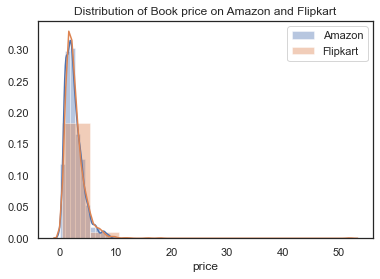

In [159]:
def plot_histogram(ls_1, ls_2, feature):
    sns.distplot(ls_1, hist=True, bins=10, kde=True, label='Amazon')
    sns.distplot(ls_2, hist=True, bins=10, kde=True, label='Flipkart')
    plt.legend()
    plt.title(f'Distribution of Book {feature} on Amazon and Flipkart')
    plt.show()
    
plot_histogram(amzn_df['price'], fp_df['price'], 'price')

### Uh oh, we have outliers!
This distribution is hard to bin, due to what seems to be the presence of outliers. How about we confirm that, using a boxplot:

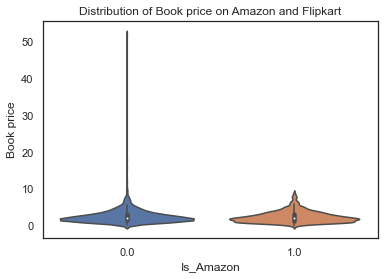

In [157]:
def make_boxplot(data, feature):
    fig, ax = plt.subplots()
    sns.violinplot(x="Is_Amazon", y=feature, data=data)
    plt.title(f'Distribution of Book {feature} on Amazon and Flipkart')
    ax.set_ylabel(f"Book {feature}")
    plt.show()
    
make_boxplot(all_books_mixed, 'price')

**Oh wow!** Amazon has much more outliers than Flipkart. How about we replot the PDF without those? 

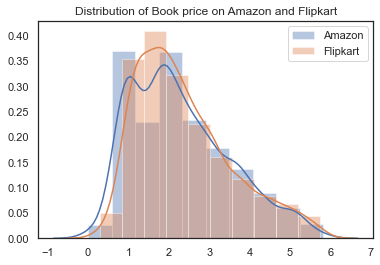

In [163]:
def find_remove_outlier_iqr(data_sample):
    """Removes outliers from a data_sample (array-like object) based on interquartile range.
       Credit for implementation goes to Ian Birnam, at
       https://github.com/UPstartDeveloper/DS-1.1-Data-Analysis/blob/master/Notebooks/Outlier_Correlation_StatisticalAnalysis.ipynb

    """
    # calculate interquartile range
    q25, q75 = np.percentile(data_sample, 25), np.percentile(data_sample, 75)
    iqr = q75 - q25
    # calculate the outlier cutoff
    cut_off = iqr * 1.5
    lower, upper = q25 - cut_off, q75 + cut_off
    # identify outliers
    outliers = [x for x in data_sample if x < lower or x > upper]
    # remove outliers
    outliers_removed = [x for x in data_sample if x > lower and x < upper]
    return outliers_removed

def replot_histogram(df1, df2, feature):
    '''Remove outliers from the list of values for a feature across two DataFrames,
       and then plots their PDF'''
    # removing the outliers
    amzn_prices_no_outliers = find_remove_outlier_iqr(df1[feature])
    fp_prices_no_outliers = find_remove_outlier_iqr(df2[feature])
    # replotting the histogram
    plot_histogram(amzn_prices_no_outliers, fp_prices_no_outliers, feature)
    
replot_histogram(amzn_df, fp_df, 'price')

### Interesting!
For the most part book prices seem to fall into the same distribution on both marketplaces. However, Flipkart seem to have a higher mean price than Amazon.

## Distribution of Ratings between Companies
First of all, let's make sure we know the range of ratings, rather than assuming it's 0-5 stars.

In [99]:
print(f"Highest book rating on Amazon: {amzn_df['rating'].max()}")
print(f"Lowest book rating on Amazon: {amzn_df['rating'].min()}")
print(f"Maximum book rating on Flipkart: {fp_df['rating'].max()}")
print(f"Maximum book rating on Flipkart: {fp_df['rating'].min()}")

Highest book rating on Amazon: 5.0
Lowest book rating on Amazon: 0.0
Maximum book rating on Flipkart: 5.0
Maximum book rating on Flipkart: 0.0


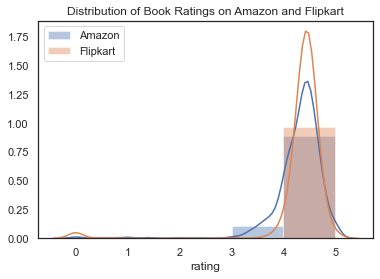

In [100]:
sns.distplot(amzn_df['rating'] , hist=True, bins=5, kde=True, label='Amazon')
sns.distplot(fp_df['rating'], hist=True, bins=5, kde=True, label='Flipkart')
plt.legend()
plt.title('Distribution of Book Ratings on Amazon and Flipkart')
plt.show()

Like prices, Flipkart book ratings appears to have a higher mean their Amazonian counterparts. As well, then are outliers to account for like before.

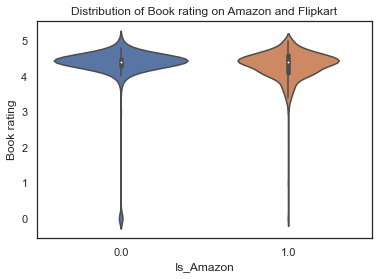

In [164]:
# plotting the boxplots of book ratings for both companies
make_boxplot(all_books_mixed, 'rating')

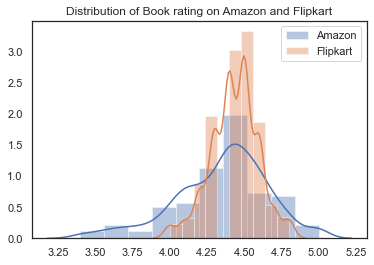

In [165]:
# Replot the Histogram, after Removing Outliers
replot_histogram(amzn_df, fp_df, 'rating')

### Upon Closer Inspection...
This gives a much better look! Like before we are able to see books on Flipkart tend to get a higher mean rating, than books of the *same title*, being sold on Amazon. We can also see there's an entire rating range (around 4.3-4.5) than Flipkart doesn't even have samples for, but which Amazon does.

## Distribution of Review Counts between Companies

In [101]:
def determine_range(df, col):
    return df[col].max() - df[col].min()

amzn_rcount_range = determine_range(amzn_df, 'reviews count')
fp_rcount_range = determine_range(fp_df, 'reviews count')
print(f'Range of review counts on Amazon: {amzn_rcount_range}')
print(f'Range of review counts on Flipkart: {fp_rcount_range}')

Range of review counts on Amazon: 6566.0
Range of review counts on Flipkart: 48324.0


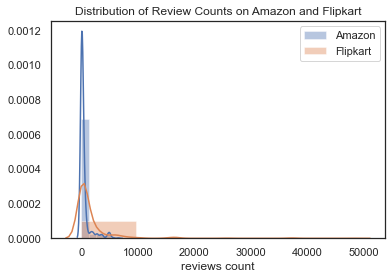

In [102]:
sns.distplot(amzn_df['reviews count'] , hist=True, bins=5, kde=True, label='Amazon')
sns.distplot(fp_df['reviews count'], hist=True, bins=5, kde=True, label='Flipkart')
plt.legend()
plt.title('Distribution of Review Counts on Amazon and Flipkart')
plt.show()

The pattern continues! Once again, Amazon shows off the stability of its platform, showing a much less variance than Flipkart does for the same statistic, regardless of the fact we are comparing the same books on both platforms. 

Before moving ahead let's zoom in on this distribution as well, by removing outliers and replotting the histogram! This will help ensure we are not losing too much information due to the presence of outliers.

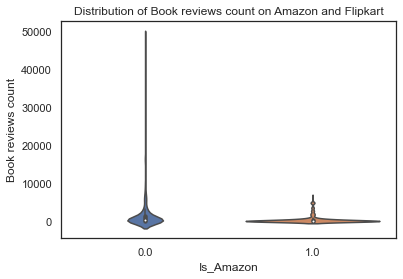

In [169]:
# plotting the boxplots of numberso of reviews for both companies
make_boxplot(all_books_mixed, 'reviews count')

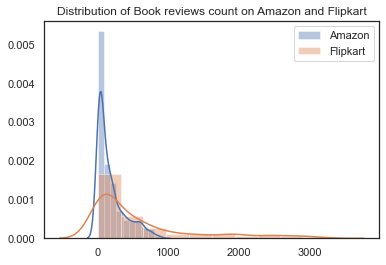

In [170]:
# Replot the Histogram, after Removing Outliers
replot_histogram(amzn_df, fp_df, 'reviews count')

Not much appears to have changed on this replotted histogram! Much of the same distribution is still observed, compared to when outliers were included.

At this point, is unclear from which of the two DataFrames that the outliers have been removed from. Let's be sure to check on that! If the lengths are still the same, then we can safely modify the combined DataFrame, and continue in this exploration.

In [178]:
if len(amzn_df.all().iloc[:]) == len(fp_df.all().iloc[:]):
    print('Classes are still balanced!')
    
# reinitializing the combined df
all_books_mixed = collect_rows(amzn_df, fp_df, False)

Classes are still balanced!


## Correlation Heatmap
How much correlation do price, rating, and review count have with our target, the company class?
How much multicolinearity do they have with each other?

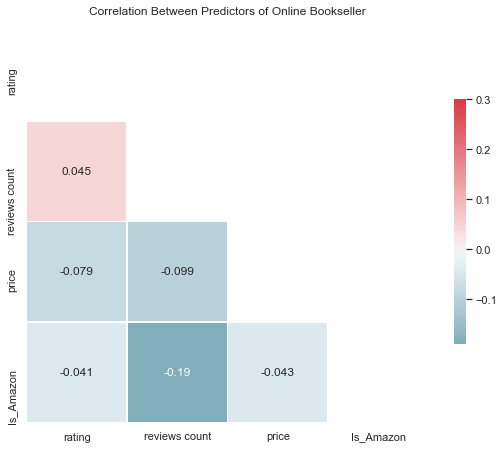

In [179]:
def make_heatmap(df, map_title):
    """Plots the diagonal correlation matrix of a dataset using Seaborn.
       Credit to the Seaborn Documentation for inspiring this cell:
       https://seaborn.pydata.org/examples/many_pairwise_correlations.html
       
       Parameters:
       df(pandas.DataFrame): encapsulates the dataset being used to make heatmap.
       map_title(str): the title for the heatmap
    
    """
    sns.set(style="white")
    # Compute the correlation matrix
    corr = df.corr()
    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=np.bool))
    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(9, 9))
    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)
    plt.title(map_title)
    plt.show()
    
make_heatmap(all_books_mixed, 'Correlation Between Predictors of Online Bookseller')

This highlights an important notion: the correlation between 'reviews count' and 'rating' suggests that due to greater public satisfaction, the books that have a high number of reviews also correlate to having a higher rating. 


Before going any further it would be useful to normalize the dataset so that all the values are on the same scale, whereas currently - the values for 'reviews count' tend to be much higher than the other numerical columns.

# Preparing the Data for ML

## Splitting into Training and Testing

In [180]:
def split_scale_data(df, features, target_var):
    """Separate the data into inputs and outputs, as well as training and testing data.
    
    """
    # split the data
    X = df[features]
    y = df[target_var]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)
    return X_train, X_test, y_train, y_test

features = ['price', 'reviews count', 'rating']
target = 'Is_Amazon'
X_train, X_test, y_train, y_test = split_scale_data(all_books_mixed, features, target)

## Applying Standard Scaling

In [181]:
s_scaler = StandardScaler()
X_train_standard_scaled = s_scaler.fit_transform(X_train)
X_test_standard_scaled = s_scaler.transform(X_test)

## Applying MinMax Scaling

In [182]:
mm_scaler = MinMaxScaler()
X_train_mm_scaled = mm_scaler.fit_transform(X_train)
X_test_mm_scaled = mm_scaler.transform(X_test)

## PCA - do we need it?

### Reducing to 1 Principal Component

In [183]:
def apply_pca(data, num_components, is_scaled):
    '''Get a certain number of principal components for a dataset. Prints the explained variance ratios.'''
    # PCA computation using sklearn
    pca = PCA(n_components=num_components)
    data_reduced = pca.fit_transform(data)
    # determine if to print 'Scaled' or not
    if is_scaled is True:
        scale = 'Scaled'
    else:
        scale = 'Un-scaled'
    # Display resulting explained variance
    print(f'Variance Retained using PCA on {scale} Training Data, with {num_components} Components')
    print(pca.explained_variance_) 
    print(pca.explained_variance_ratio_)
    ratio = pca.explained_variance_ratio_.cumsum()
    print(ratio)
    print('---------------------------------------')
    
    return data_reduced
    
apply_pca(X_train_standard_scaled, 1, True)
apply_pca(X_train, 1, False)
apply_pca(X_train_standard_scaled, 2, True)
X_train_reduced = apply_pca(X_train, 2, False)

Variance Retained using PCA on Scaled Training Data, with 1 Components
[1.17782776]
[0.39241986]
[0.39241986]
---------------------------------------
Variance Retained using PCA on Un-scaled Training Data, with 1 Components
[7494118.76900407]
[0.99999947]
[0.99999947]
---------------------------------------
Variance Retained using PCA on Scaled Training Data, with 2 Components
[1.17782776 0.94799806]
[0.39241986 0.31584692]
[0.39241986 0.70826678]
---------------------------------------
Variance Retained using PCA on Un-scaled Training Data, with 2 Components
[7.49411877e+06 3.68557108e+00]
[9.99999472e-01 4.91794865e-07]
[0.99999947 0.99999996]
---------------------------------------


Performing PCA on unscaled data with 2 principal components gave us the best explained variance. However, overall I think it is not worth using PCA in this dataset, because the number of features is already fairly small. As well, using this form of reduced data will lead to other problems in throwing off the bias of the classifier model, since the scales are thrown off (as you can see below).

Most likely, the spread of values in the reduced version of unscaled data is just making PCA *think* that it has retained a lot of the variance. However, that should not offer major benefits because as previously seen in the heatmap above, there's not a lot of correlation in this dataset to begin with.

In [184]:
print(X_train_reduced)

[[-9.53797753e+02  4.64142786e+00]
 [-7.65797504e+02  1.41012815e+00]
 [-1.01179753e+03  1.66503811e+00]
 ...
 [-4.73797407e+02  1.58934641e-01]
 [-6.71797407e+02  1.43571380e-01]
 [ 1.60620274e+03 -1.68887403e+00]]


# Implementation of Different Classifer Models

## Support Vector Machine

### Grid Search

In [185]:
def svc_param_selection(X, y, nfolds, kernel_type):
    """Return the optimal hyperparameters to use on a Support Vector Machine classifier.
       Credit to Milad Toutounchian for the following implementation, found at:
       https://github.com/Make-School-Courses/DS-2.1-Machine-Learning/blob/master/Notebooks/simple_Model_Evaluation.ipynb
       
       Parameters:
       X(array-like): features of the dataset that are input to the model to make its classification
       y(array-like): feature of the dataset being targeted for classification
       nfolds(int): specificies the number of divisions to make in the data, as a cross validation strategy
       kernel_type(str): the type of kernel for the SVC we are optimizing
       
       Returns: dict: param settings that gave the best result
    """
    Cs = [0.001, 0.01, 0.1, 1, 10]
    gammas = [0.001, 0.01, 0.1, 1]
    # only use gammas if using for Radial Basis Function
    if kernel_type == 'rbf':
        param_grid = {'C': Cs, 'gamma' : gammas}
    else:
        param_grid = {'C': Cs}
    grid_search = GridSearchCV(SVC(kernel=kernel_type), param_grid, cv=nfolds, n_jobs=3, scoring='accuracy')
    grid_search.fit(X, y)
    return grid_search.best_params_


# collecting all the best hyperparams for SVM in one
kernels = ['linear', 'poly', 'rbf']
s_scaled_kernel_params = {}
X = all_books_mixed[features]
X_standard_scaled = s_scaler.transform(X)
y = all_books_mixed['Is_Amazon']
for kernel in kernels:
    s_scaled_kernel_params[kernel] = svc_param_selection(X_standard_scaled, y, 5, kernel)

In [186]:
s_scaled_kernel_params

{'linear': {'C': 10}, 'poly': {'C': 10}, 'rbf': {'C': 10, 'gamma': 1}}

### Would the values for these hyperparameters change, if we changed the type of scaling used?

In [187]:
mm_scaled_kernel_params = {}
X_mm_scaled = mm_scaler.transform(X)
# iterate over the same three kernels
for kernel in kernels:
    mm_scaled_kernel_params[kernel] = svc_param_selection(X_standard_scaled, y, 5, kernel)
mm_scaled_kernel_params

{'linear': {'C': 10}, 'poly': {'C': 10}, 'rbf': {'C': 10, 'gamma': 1}}

### Which Kernel Performs the Best, on Standard Scaled Data? (Confusion Matrix)

In [188]:
def calculate_rate(numerator, denominator):
        '''Return the percent value for a statistical formula.'''
        return round(numerator/denominator, 2) * 100

def print_confusion_metrics(cm):
    '''Prints metrics of the model, derived from the confusion matrix.'''
    TN, FP, FN, TP = cm.ravel()
    # calculate the metrics
    accuracy, precision, recall = (
        calculate_rate(TP + TN, TP + TN + FP + FN),
        calculate_rate(TP, TP + FP),
        calculate_rate(TP, TP + FN)
    )
    f1 = round((2 * precision * recall)/(float(precision + recall)), 4)
    # display the results
    print('CONFUSION MATRIX METRICS')
    print(f'Accuracy: {accuracy}%')
    print(f'Precision: {precision}%')
    print(f'Recall: {recall}%')
    print(f'F1-Score: {f1}%')
    return None
   
def run_svm_and_evaluate(kernel_type, X_train, y_train, X_test, y_test):
    """Evaluate the Support Vector Machine performance on each kernel, with optimized hyperparams 
       and same data.
       
       Returns: None
       
    """
    # initialize variables to defaults in sklearn, then switch to optimized values
    gamma_value = 'scale' 
    if kernel_type == 'rbf':
        gamma_value = kernel_params[kernel_type]['gamma']
    C_value =  kernel_params[kernel_type]['C']
     # instantiate the Support Vector Machine, with the optimized hyperparams
    svm = SVC(kernel=kernel_type, C=C_value, gamma=gamma_value)
    # train the model, then test it!
    svm.fit(X_train, y_train)
    y_pred = svm.predict(X_test)
    # produce results using the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print_confusion_metrics(cm)
    # return the model
    return svm

standard_svms = list()
for kernel in kernels:
    print(f'Performance of {kernel} kernel')
    svm = run_svm_and_evaluate(kernel, X_train_standard_scaled, y_train, X_test_standard_scaled, y_test)
    standard_svms.append(svm)
    print('\n')

Performance of linear kernel
CONFUSION MATRIX METRICS
Accuracy: 57.99999999999999%
Precision: 56.00000000000001%
Recall: 91.0%
F1-Score: 69.3333%


Performance of poly kernel
CONFUSION MATRIX METRICS
Accuracy: 61.0%
Precision: 57.99999999999999%
Recall: 91.0%
F1-Score: 70.8456%


Performance of rbf kernel
CONFUSION MATRIX METRICS
Accuracy: 71.0%
Precision: 73.0%
Recall: 72.0%
F1-Score: 72.4966%




### Try Evaluating the SVM again with MinMax Scaled Data!

In [189]:
mm_svms = list()
for kernel in kernels:
    print(f'Performance of {kernel} kernel')
    svm = run_svm_and_evaluate(kernel, X_train_mm_scaled, y_train, X_test_mm_scaled, y_test)
    mm_svms.append(svm)
    print('\n')

Performance of linear kernel
CONFUSION MATRIX METRICS
Accuracy: 57.99999999999999%
Precision: 56.00000000000001%
Recall: 91.0%
F1-Score: 69.3333%


Performance of poly kernel
CONFUSION MATRIX METRICS
Accuracy: 59.0%
Precision: 56.99999999999999%
Recall: 91.0%
F1-Score: 70.0946%


Performance of rbf kernel
CONFUSION MATRIX METRICS
Accuracy: 59.0%
Precision: 56.99999999999999%
Recall: 82.0%
F1-Score: 67.2518%




**And the Winner is: the Polynomial Kernel!**

In our use case, it makes sense to optimize for a "happy medium" between having both high scores for precision and recall rather than just recall, because deciding where to buy books is a relatively low-risk classification problem, so the false negatives are not to be a major issue. As a result, the most important metric to look at derived from our confusion matrix is the F1-score, which factors in both the precision and recall.

The other fact to bear in mind is that there is very little variance in this dataset, as seen earlier. As a result it becomes noteworthy if a certain kernel helps us increase the recall, because that means the model is able to handle the false negatives (books that were classified as being on Flipkart, but were really being sold on Amazon). 

For this reason the polynomial kernel stands out. For both using standard and minmax scaling algorithms, the support vector machine using the polynomial kernel had the best combination of both high F1-Score and Recall. 

## Logistic Regression
What if we want to know the probabilities behind the classifications of the model? It's time to use Logistic Regression!

In [68]:
# Creating the Model
logreg = LogisticRegression(random_state=0, solver="lbfgs")
logreg.fit(X_train_standard_scaled, y_train)
# Testing the Model
y_pred = logreg.predict(X_test_standard_scaled)
cm = confusion_matrix(y_test, y_pred)
print_confusion_metrics(cm)

CONFUSION MATRIX METRICS
Accuracy: 62.23%
Precision: 59.88%
Recall: 83.93%
F1-Score: 69.894%


## K-Nearest Neighbors

## Which Model is the Best? (Cross Validation)

# Final Conclusions